# Medical School issues Medical Qualification to Doctor

## Before running through this notebook you have configured the agent in [Part 1](http://localhost:8888/notebooks/Part%202%20-%20Writing%20a%20Public%20DID%20to%20the%20Sovrin%20StagingNet.ipynb).



## 1. Initialise a controller for Medical School

In [1]:
%autoawait
import time
import asyncio
from termcolor import colored,cprint

from aries_basic_controller.aries_controller import AriesAgentController
    
WEBHOOK_HOST = "0.0.0.0"
WEBHOOK_PORT = 8022
WEBHOOK_BASE = ""
ADMIN_URL = "http://medical-school-agent:8021"

# Based on the aca-py agent you wish to control
agent_controller = AriesAgentController(webhook_host=WEBHOOK_HOST, webhook_port=WEBHOOK_PORT,
                                       webhook_base=WEBHOOK_BASE, admin_url=ADMIN_URL)
    

IPython autoawait is `on`, and set to use `asyncio`


## 2. Register Listeners

The handler should get called every time the controller receives a webhook with the topic issue_credential, printing out the payload. The agent calls to this webhook every time it receives an issue-credential protocol message from a credential.

In [2]:
loop = asyncio.get_event_loop()
loop.create_task(agent_controller.listen_webhooks())

def cred_handler(payload):
    print("Handle Credentials")
    exchange_id = payload['credential_exchange_id']
    state = payload['state']
    role = payload['role']
    attributes = payload['credential_proposal_dict']['credential_proposal']['attributes']
    print(f"Credential exchange {exchange_id}, role: {role}, state: {state}")
    print(f"Offering: {attributes}")
    
cred_listener = {
    "topic": "issue_credential",
    "handler": cred_handler
}

def connections_handler(payload):
    global STATE
    connection_id = payload["connection_id"]
    print("Connection message", payload, connection_id)
    STATE = payload['state']
    if STATE == 'active':
#         print('Connection {0} changed state to active'.format(connection_id))
        print(colored("Connection {0} changed state to active".format(connection_id), "red", attrs=["bold"]))


connection_listener = {
    "handler": connections_handler,
    "topic": "connections"
}

agent_controller.register_listeners([cred_listener,connection_listener], defaults=True)


## 3 Use a previously written schema

In [3]:
schema_id = '2yWoMSfeTtYBFpUJFcnpqL:2:Medical Qual:0.0.1'

## 4. Write a Credential Definition to the Ledger

**Note: Again this can only be done once per issuer, per schema_id.**

In [4]:
response = await agent_controller.definitions.write_cred_def(schema_id)

cred_def_id = response["credential_definition_id"]
print(cred_def_id)

WEhNYuEVXBo1GXec4ZuMmu:3:CL:141255:default


**Note: You should be able to see both schema and definition transactions on Sovrin Stagingnet network with [Indyscan](https://indyscan.io/home/SOVRIN_STAGINGNET)**

## 5. Populate the Attribues to Issue to Idenity Holder (User)

We will issue a credential to the identity holder consisting of the following attributes:


2yWoMSfeTtYBFpUJFcnpqL:2:Medical Qual:0.0.1
{
       "attrNames":[
           "MDQ Primary Medical Qual",
           "MDQ Issuing Institution",
           "MDQ Surname",
           "MDQ Given Names",
           "MDQ Issue Date"
       ],
       "name":"Medical Qual",
       "version":"0.0.1"
}


The notebook will ask you to input the identity holder's full name and age which will be used to populate the schema above with the identity holders attribute information.

In [5]:
qualification=input("Please enter your qualification: ")
institution=input("Please enter qualification institution: ")
surname=input("Please enter your surname: ")
name=input("Please enter your name: ")
issue_date=input("Please enter the qualification issue date: ")

credential_attributes = [
    {"name": "MDQ Primary Medical Qual", "value": qualification},
    {"name": "MDQ Issuing Institution", "value": institution},
    {"name": "MDQ Surname", "value": surname},
    {"name": "MDQ Given Names", "value": name},
    {"name": "MDQ Issue Date", "value": issue_date}
]
print(credential_attributes)

Please enter your qualification: MSc Comp Sci
Please enter qualification institution: Rhodes
Please enter your surname: Spies
Please enter your name: Lohan
Please enter the qualification issue date: 2020-12-31
[{'name': 'MDQ Primary Medical Qual', 'value': 'MSc Comp Sci'}, {'name': 'MDQ Issuing Institution', 'value': 'Rhodes'}, {'name': 'MDQ Surname', 'value': 'Spies'}, {'name': 'MDQ Given Names', 'value': 'Lohan'}, {'name': 'MDQ Issue Date', 'value': '2020-12-31'}]


## 7. Download Identity Holder Mobile SSI Wallet
Please download a mobile SSI wallet such as [Connect.me](https://connect.me/), [Trinsic](https://trinsic.id/trinsic-wallet/) or any other Aries compatible wallet.

## 8. Create a connection invitation to scan with the Mobile SSI Wallet

To make a connection with an identity holders wallet we must create a connection invitation and present the QR code to be scanned by the identity holders wallet. The identity holder scan this QR code and then communicate back to the agent through the exposed ngrok endpoint.

Once a connection is in an active state, the agent and the identity holders mobile wallet now have a secure pairwise relationship over which they can exchange verifiable credentials.

## 8a. Check for any existing connections

In [6]:
# Check for existing connections
connection = await agent_controller.connections.get_connections()
print("EXISTING CONNECTIONS")
for key, value in connection.items():
    for item in value:
        print('ConnectionID:', item['connection_id'], 'Status:',item['state'])

EXISTING CONNECTIONS
ConnectionID: 19520f30-4d1f-41ef-8ddc-af7775186cba Status: active
ConnectionID: 376256ae-8a5e-42b0-b5d3-837ebc4ea429 Status: active


## 8b. Create an Invitation

In [7]:
# Create Invitation
invite = await agent_controller.connections.create_invitation()
connection_id = invite["connection_id"]
print("Connection ID", connection_id)
print("Invitation")
print(invite['invitation_url'])
inviteURL = invite['invitation_url']

Connection ID df4d95b6-53ec-44a2-8dd7-0ed4ab0686df
Invitation
http://18ffa296af94.ngrok.io?c_i=eyJAdHlwZSI6ICJkaWQ6c292OkJ6Q2JzTlloTXJqSGlxWkRUVUFTSGc7c3BlYy9jb25uZWN0aW9ucy8xLjAvaW52aXRhdGlvbiIsICJAaWQiOiAiYTYwYWM0MGMtZGQwOC00MzdlLTlhZDUtMzVjZDMyZmJlMjNmIiwgInNlcnZpY2VFbmRwb2ludCI6ICJodHRwOi8vMThmZmEyOTZhZjk0Lm5ncm9rLmlvIiwgInJlY2lwaWVudEtleXMiOiBbIjRyS0pLa1JzSkFpRnBSMTY0bjRSOWZRanJia2Z3NThVQlE1c0hhQjdETFQyIl0sICJsYWJlbCI6ICJNZWRpY2FsIFNjaG9vbCJ9
Connection message {'routing_state': 'none', 'initiator': 'self', 'created_at': '2020-09-21 15:06:02.406159Z', 'connection_id': 'df4d95b6-53ec-44a2-8dd7-0ed4ab0686df', 'updated_at': '2020-09-21 15:06:02.406159Z', 'state': 'invitation', 'accept': 'auto', 'invitation_mode': 'once', 'invitation_key': '4rKJKkRsJAiFpR164n4R9fQjrbkfw58UBQ5sHaB7DLT2'} df4d95b6-53ec-44a2-8dd7-0ed4ab0686df


## 8c. Generate QR Code to be scanned with Mobile SSI Wallet

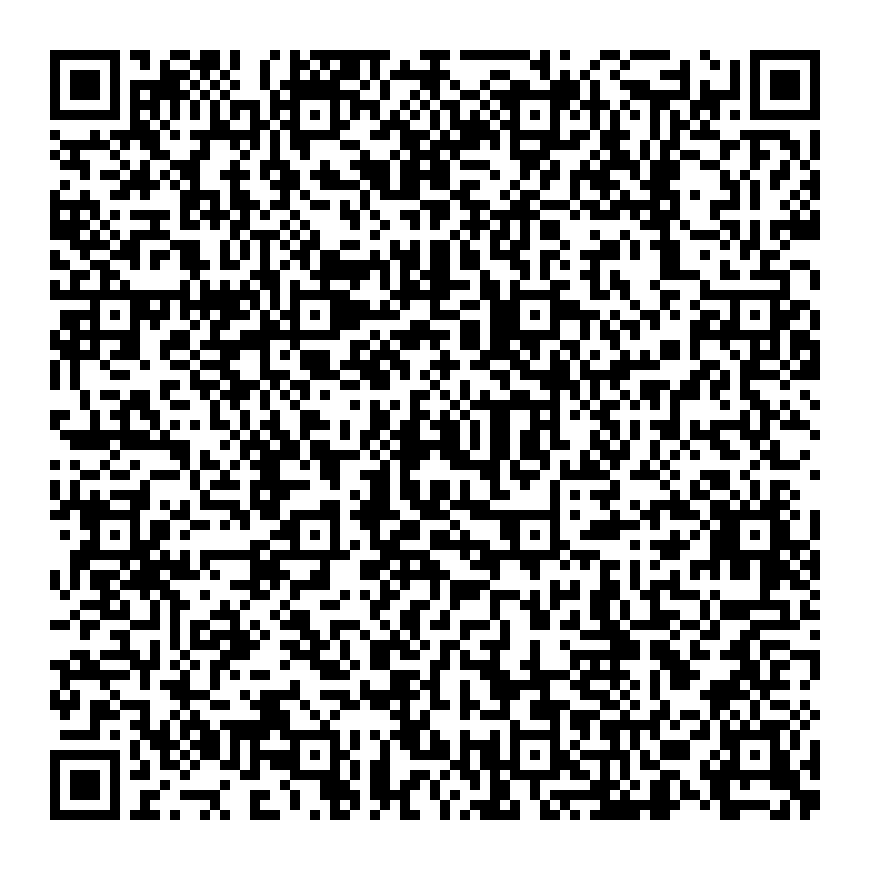

Connection message {'their_did': 'Gqn94Zev7WGmxtCZcXujKp', 'routing_state': 'none', 'initiator': 'self', 'their_label': 'EAX', 'created_at': '2020-09-21 15:06:02.406159Z', 'connection_id': 'df4d95b6-53ec-44a2-8dd7-0ed4ab0686df', 'updated_at': '2020-09-21 15:06:15.712284Z', 'state': 'request', 'accept': 'auto', 'invitation_mode': 'once', 'invitation_key': '4rKJKkRsJAiFpR164n4R9fQjrbkfw58UBQ5sHaB7DLT2'} df4d95b6-53ec-44a2-8dd7-0ed4ab0686df
Connection message {'their_did': 'Gqn94Zev7WGmxtCZcXujKp', 'routing_state': 'none', 'initiator': 'self', 'their_label': 'EAX', 'created_at': '2020-09-21 15:06:02.406159Z', 'connection_id': 'df4d95b6-53ec-44a2-8dd7-0ed4ab0686df', 'updated_at': '2020-09-21 15:06:15.738777Z', 'my_did': 'PiZWYwqNJEbdxVYhtTgeNQ', 'state': 'response', 'accept': 'auto', 'invitation_mode': 'once', 'invitation_key': '4rKJKkRsJAiFpR164n4R9fQjrbkfw58UBQ5sHaB7DLT2'} df4d95b6-53ec-44a2-8dd7-0ed4ab0686df


In [8]:
import qrcode
# Link for connection invitation
input_data = inviteURL
# Creating an instance of qrcode
qr = qrcode.QRCode(
        version=1,
        box_size=10,
        border=5)
qr.add_data(input_data)
qr.make(fit=True)
img = qr.make_image(fill='black', back_color='white')
img.save('medical-school-agent_invite_QRcode.png')

from IPython.display import Image
Image(width=400, filename='./medical-school-agent_invite_QRcode.png')

## 8d. Check if established connection is in active state

In [9]:
import time

# print('Current state for ConnectionId {} is {}'.format(connection_id,STATE))
print(colored("Current state for ConnectionId {} is {}".format(connection_id,STATE), "magenta", attrs=["bold"]))
while STATE != 'active':
#     print('ConnectionId {0} is not in active state yet'.format(connection_id))
    print(colored("ConnectionId {0} is not in active state yet".format(connection_id), "yellow", attrs=["bold"]))
    trust_ping = await agent_controller.messaging.trust_ping(connection_id,'hello!')
#     print('Trust ping send to ConnectionId {0} to activate connection'.format(trust_ping))
    print(colored("Trust ping send to ConnectionId {0} to activate connection".format(trust_ping), "blue", attrs=["bold"]))
    time.sleep(5)
    
# print('ConnectionId: {0} is now active. Continue with notebook'.format(connection_id))
print(colored("ConnectionId: {0} is now active. Continue with notebook".format(connection_id), "green", attrs=["bold"]))


Current state for ConnectionId df4d95b6-53ec-44a2-8dd7-0ed4ab0686df is response
ConnectionId df4d95b6-53ec-44a2-8dd7-0ed4ab0686df is not in active state yet
Trust ping send to ConnectionId {'thread_id': '98569ef3-c58b-4a04-b950-29e45f52db4b'} to activate connection
ConnectionId df4d95b6-53ec-44a2-8dd7-0ed4ab0686df is not in active state yet
Connection message {'their_did': 'Gqn94Zev7WGmxtCZcXujKp', 'routing_state': 'none', 'initiator': 'self', 'their_label': 'EAX', 'created_at': '2020-09-21 15:06:02.406159Z', 'connection_id': 'df4d95b6-53ec-44a2-8dd7-0ed4ab0686df', 'updated_at': '2020-09-21 15:06:19.814883Z', 'my_did': 'PiZWYwqNJEbdxVYhtTgeNQ', 'state': 'active', 'accept': 'auto', 'invitation_mode': 'once', 'invitation_key': '4rKJKkRsJAiFpR164n4R9fQjrbkfw58UBQ5sHaB7DLT2'} df4d95b6-53ec-44a2-8dd7-0ed4ab0686df
Connection df4d95b6-53ec-44a2-8dd7-0ed4ab0686df changed state to active
Trust ping send to ConnectionId {'thread_id': 'be365e70-cd50-461b-a2fd-461680e13cd9'} to activate connection

## 9. Send Credential

This sends a credential to a identity holder (User), and automates the rest of the protocol.

There are other ways to issue a credential that require multiple api calls.

**Arguments**
* connection_id: The connection_id of the holder you wish to issue to (MUST be in active state)
* schema_id: The id of the schema you wish to issue
* cred_def_id: The definition (public key) to sign the credential object. This must refer to the schema_id and be written to the ledger by the same public did that is currently being used by the agent.
* attributes: A list of attribute objects as defined above. Must match the schema attributes.
* comment (optional): Any string, defaults to ""
* auto_remove (optional): Boolean, defaults to True. I believe this removes the record of this credential once it has been issued. (TODO: double check)
* trace (optional): Boolean, defaults to False. **Not entirely sure about this one, believe its for logging. Also when set to True it throws an error**

In [10]:
record = await agent_controller.issuer.send_credential(connection_id, schema_id, cred_def_id, credential_attributes, trace=False)
record_id = record['credential_exchange_id']
state = record['state']
role = record['role']
print(f"Credential exchange {record_id}, role: {role}, state: {state}")


Handle Credentials
Credential exchange 316fd963-f457-4a75-921d-379ecd8862d9, role: issuer, state: offer_sent
Offering: [{'name': 'MDQ Primary Medical Qual', 'value': 'MSc Comp Sci'}, {'name': 'MDQ Issuing Institution', 'value': 'Rhodes'}, {'name': 'MDQ Surname', 'value': 'Spies'}, {'name': 'MDQ Given Names', 'value': 'Lohan'}, {'name': 'MDQ Issue Date', 'value': '2020-12-31'}]
Credential exchange 316fd963-f457-4a75-921d-379ecd8862d9, role: issuer, state: offer_sent
Handle Credentials
Credential exchange 316fd963-f457-4a75-921d-379ecd8862d9, role: issuer, state: request_received
Offering: [{'name': 'MDQ Primary Medical Qual', 'value': 'MSc Comp Sci'}, {'name': 'MDQ Issuing Institution', 'value': 'Rhodes'}, {'name': 'MDQ Surname', 'value': 'Spies'}, {'name': 'MDQ Given Names', 'value': 'Lohan'}, {'name': 'MDQ Issue Date', 'value': '2020-12-31'}]
Handle Credentials
Credential exchange 316fd963-f457-4a75-921d-379ecd8862d9, role: issuer, state: credential_issued
Offering: [{'name': 'MDQ Pri

## 10. Accept credential in Mobile SSI Wallet

## 11. End of Tutorial

Be sure to terminate the controller so you can run another tutorial.

In [18]:
response = await agent_controller.terminate()
print(response)

None


# Proceed to Interact with the [General Medical Council](http://localhost:8890) to receive your Doctor's Licence.

You can get the token for this notebook by running `docker logs  interopen-hack_gmc-notebook_1`